## Simulation Environments (last updated 21.04.27)
- CU with local dataset
- **Local dataset**: Unbalanced (3 classes/local dataset), Non-i.i.d., non-overapped samples
- **Channel**: Pathloss + Rayleigh fading
- **Power Allocation**: Truncated Channel Inversion
- **Transmission type**: Analog Transmission with Orthogonal sub-channel allocation
- **Fixed device deployment** and **Fixed local dataset**

- CU and deivces have the same weight for the model update

In [1]:
import sys, os
sys.path.append('/workspace/shared/')

In [2]:
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import math
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))        
        x = self.pool(torch.tanh(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4)
        #x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

### Default Setup *(Do not modify)*

In [4]:
lr =  0.1
batch_local = 10   # Size of local minibatch
E = 3 #3  # Local training epoch
epoch_max = 300
D = sum( p.numel() for p in net.parameters() if p.requires_grad)   # Number of parameters in model, 582,026 

noise_pow_dBm = -50 #-100
P_dBm = 20

B = 1024    # Number of subcarrier

cell_radius = 400   # Distance to the farthest devices
density = 250/(np.pi*500**2)   # 200 devices within 500m in average
pathloss_exponent = 4

num_classes = 3   # Number of classes in local dataset
samples_avg_local = 200   # Average number of local samples
samples_CU = samples_avg_local   # Average number of samples at CU

regul_coeff = 10e-5   # L2 regularization parameter for avoding overfitting
#init_E = E   # Pre-training epoch

### Variations in Setup *(Adjustable)*

In [5]:
cell_radius = 150

### Load Simulation Setups

In [6]:
PATH_DEPLOYMENT = '../shared/simulation_setups/Deployment_within_550.npy'
PATH_TRAIN_DATASET = '../shared/simulation_setups/train_dataset.pth'
PATH_LOCAL_DATASET = '../shared/simulation_setups/localdataset_within_550.npy'

dev_deployment = np.load(PATH_DEPLOYMENT)        # Deployment of devices within 550 meters
trainset = torch.load(PATH_TRAIN_DATASET)         # Load training data and labels
x, y = trainset.values()
idx_localDB = np.load(PATH_LOCAL_DATASET, allow_pickle=True)        # Classified data indices

### Subordinate System Parameters *(Do not modify)*

In [7]:
g_th = 0.5 * cell_radius ** -pathloss_exponent
noise_pow = 10**(noise_pow_dBm/10)
P = 10**(P_dBm/10)
N = int(np.ceil(D/B))   # Number of transmit symbols
dev_num = np.sum((np.linalg.norm(dev_deployment, axis=1)<cell_radius))   # Number of devices
samples_local = [ len(idx_localDB[i]) for i in range(dev_num)]     # Number of samples at devices
samples_global = samples_CU+np.sum(samples_local)
print('Number of participating devices: ', dev_num)
print('Number of utilized samples:', samples_global)

dev_dist = np.linalg.norm(dev_deployment[:dev_num], axis=1)
pathloss = dev_dist**-pathloss_exponent
print('Link distances: ', dev_dist[0:5])
print('Pathloss: ', pathloss[0:5])

permute_idx = np.random.permutation(B*N)
permute_idx_inv = np.argsort(permute_idx)

Number of participating devices:  25
Number of utilized samples: 5278
Link distances:  [22.83855181 34.12266929 41.28552959 42.75910894 59.44096671]
Pathloss:  [3.67557892e-06 7.37612065e-07 3.44198173e-07 2.99147525e-07
 8.01044318e-08]


In [8]:
########### Data classification ##############
idx = []   # Empty list
for i in range(10):
    tmp = list((y==i).nonzero()[0])
    idx.append(tmp)
    
############ CU dataset ############
CU_x = torch.zeros(samples_CU,1, 28, 28)
CU_y = np.zeros(samples_CU, dtype=int)
CU_dataset = []
for i in range(10):
    CU_dataset += idx[i][:int(samples_CU/10)]
random.shuffle(CU_dataset)
    
for i, idx_CU in enumerate(CU_dataset):
    CU_x[i], CU_y[i] = x[idx_CU], y[idx_CU]

################### Test dataset ##################
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='../shared/MNIST_dataset/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False, num_workers=3)

classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

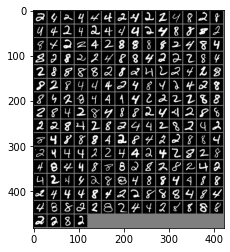

2, 4, 2, 4, 4, 4, 2, 4, 2, 2, 4, 8, 2, 8,


In [9]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images = x[idx_localDB[0]]
labels = y[idx_localDB[0]]

# show images
first_row = int(np.sqrt(samples_local[0]))
imshow(torchvision.utils.make_grid(images, nrow=first_row))
# print labels
print(' '.join('%d,' % classes[labels[j]] for j in range(int(first_row))))

In [10]:
def model_localupdate(inputs, labels, net_org, E, batch_local, samples_local, lr):
    criterion = nn.CrossEntropyLoss()
    running_loss_local = 0.0
    acc_local = 0.0
    net_local = copy.deepcopy(net_org)   # deep copy of the network
    for _ in range(E):   # Local training epoch
        for b in range(int(np.ceil(samples_local/batch_local))):
            
            L2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in net_local.parameters():
                L2_reg = L2_reg + torch.norm(param, 2)
            
            start_idx = b*batch_local
            end_idx = b*batch_local+np.min([batch_local, samples_local-b*batch_local])
            outputs = net_local(inputs[start_idx:end_idx])
            loss = criterion(outputs, labels[start_idx:end_idx]) + regul_coeff*L2_reg   # 10e-4 L2-Regularization to prevent overfitting 
            net_local.zero_grad()
            loss.backward()
            
            if math.isnan(loss.item()): # Catch error
                print("outputs", outputs)
                print("inputs", inputs[start_idx:end_idx])
                w_sum = 0
                for i in net_local.parameters():
                    w_sum+=torch.sum(i)
                print('Sum of parameters: ', w_sum.item())
                ErrorOccur = input("Nan appears")
            
            with torch.no_grad():
                running_loss_local += loss.item()/(samples_local/batch_local)/E
                _, predicted = torch.max(outputs.data, 1)
                acc_local += (predicted == labels[start_idx:end_idx]).sum().item()
                for param_local in net_local.parameters():
                    param_local -= lr*param_local.grad
                    if math.isnan(torch.sum(param_local).item()):   # Catch error
                        print(param_local)
                        ErrorOccur = input("Nan appears")
                        
    return net_local, running_loss_local, acc_local      

In [11]:
def kaibin_power_allocation(P, N, B, delta_bar, h_pow, samples_local, samples_global, g_th):
    delta_pow_2d = (delta_bar**2).reshape((N, B))
    g = (1/h_pow).reshape((N,B)) 
    w = (samples_local/samples_global)**2
    tx = (1.0*(h_pow>=g_th)).reshape((N,B)) 
    #print(tx.sum())
    P_un = np.sum(w * delta_pow_2d * g * tx, 1)
    rho = P / P_un
    return rho

In [12]:
net = Net()
net.to(device)

net_diff = Net()
#net = copy.deepcopy(Model_load)
net_diff.to(device)   # Storing network update
train_acc_history = np.zeros(epoch_max)
#train_acc_history[0:len(Accuracy_load)] = Accuracy_load
update_rho_history = np.zeros(epoch_max)
#update_rho_history[0:len(RHO_load)] = RHO_load

# Pre-Training in CU
#inputs, labels = CU_x.to(device), torch.tensor(CU_y, dtype=torch.long).to(device)
#net, _, _ = model_localupdate(inputs, labels, net, init_E, batch_local, samples_CU, lr)


for epoch in range(epoch_max):  # loop over the dataset multiple times       
    ##################### Wireless Channel ###########################
    H_pow = pathloss.reshape(dev_num, 1)*np.random.exponential(1, (dev_num, B*N))    # Channel power gains, dev_num x BN
    print(H_pow[0][0])
    ########## Update at the central unit #########
    with torch.no_grad():   # Reset update
        for param_diff in net_diff.parameters():
            param_diff = torch.zeros_like(param_diff)
    
    inputs, labels = CU_x.to(device), torch.tensor(CU_y, dtype=torch.long).to(device)
    net_CU, running_loss_CU, acc_CU = model_localupdate(inputs, labels, net, E, batch_local, samples_CU, lr)
    
    idx_s = 0
    sum_update_pow = 0.0
    with torch.no_grad():
        for param_diff, param_org, param_CU in zip(net_diff.parameters(), net.parameters(), net_CU.parameters()):
            param_diff = param_CU-param_org
            param_org += param_diff*(samples_CU/samples_global)
            sum_update_pow += torch.sum(param_diff*param_diff).item()
            idx_s += param_org.numel()
       
    rho = sum_update_pow/D
    print('avg_update_SNR: %f' % (rho/noise_pow))
            
    total = samples_CU*E
    print('[epoch: %d, CU] loss: %.3f  accuracy: %.3f' % (epoch + 1, running_loss_CU, acc_CU/total))
   
    
    ########## Update at distributed devices #########
    running_loss = 0.0
    acc_tmp = 0.0
    total = 0
    X_sum = np.zeros(B*N)
    Y = np.zeros(B*N)
    
    delta_bar_all = {}
    delta_mean = 0.0
    delta_var = 0.0
    
    for i in range(dev_num):   # get local dataset of i-th device; data is a list of [inputs, labels]
        inputs, labels = x[idx_localDB[i]].to(device), torch.tensor(y[idx_localDB[i]], dtype=torch.long).to(device)
        net_local, running_loss_local, acc_local = model_localupdate(inputs, labels, net, E, batch_local, samples_local[i], lr)
        running_loss += running_loss_local
        acc_tmp += acc_local
        
        with torch.no_grad():   
            update_stack = np.array([])
            delta_bar = np.zeros(B*N)
            for param_org, param_local in zip(net.parameters(), net_local.parameters()):
                update_stack = np.concatenate((update_stack, (param_local-param_org).view(-1).to("cpu").numpy()), 0)            
            delta_bar[:D] = update_stack*1.0
            delta_bar = delta_bar[permute_idx]            
            delta_bar_all[i] = delta_bar    
            #delta_mean += np.mean(delta_bar)/dev_num
            #delta_var += np.var(delta_bar)*(B*N-1)/(B*N) / dev_num

        # print statistics
        total += E*samples_local[i]
        num_proc = max(int(dev_num/10), 1)
        if i % num_proc == num_proc-1:
            print('[epoch: %d, device: %3d] loss: %.3f  accuracy: %.3f' % (epoch + 1, i + 1, running_loss/num_proc, acc_tmp/total))
            running_loss = 0.0
            acc_tmp = 0.0
            total = 0
    
    for i in range(dev_num):
        delta_bar = delta_bar_all[i]
        #delta_bar -= delta_mean
        #delta_bar /= np.sqrt(delta_var)
        #P_alloc = power_allocation(gamma, noise_pow, P, N, B, delta_bar, H_pow[i], rho, samples_local[i], samples_global)
        
        rho_i = kaibin_power_allocation(P, N, B, delta_bar, H_pow[i], samples_local[i], samples_global, g_th)
        
        if i == 0:
            rho_min = rho_i
        else:
            rho_min = np.minimum(rho_min, rho_i)
    
    rho_min_ext = np.repeat(rho_min, B)
    
    #print(rho_min)
    #print(delta_mean)
    #print(delta_var)
    
    for i in range(dev_num):
        delta_bar = delta_bar_all[i]
        #delta_bar -= delta_mean
        #delta_bar /= np.sqrt(delta_var)
        
        tx_i = 1.0*(H_pow[i]>=g_th)
        
        X = samples_local[i]/samples_global*np.sqrt(rho_min_ext)*delta_bar*tx_i
        X_sum += X 
        
    Y = X_sum + np.sqrt(noise_pow)*np.random.randn(B*N)  
    #sss= input()
            
    #tmp = Y/rho_min_ext*np.sqrt(delta_var)+dev_num*delta_mean
    tmp = Y/np.sqrt(rho_min_ext)
    tmp = tmp[permute_idx_inv]
    delta_hat = torch.tensor(tmp).to(device)
    idx_s = 0
    with torch.no_grad():
        for param_org in net.parameters():   # Update model at the main server
            tmp_param = delta_hat[idx_s:idx_s+param_org.numel()]
            param_org += tmp_param.view(param_org.size())
            idx_s += param_org.numel()
            
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images_tmp, labels = data
            images = images_tmp.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()
    
    update_rho_history[epoch] = rho
    train_acc_history[epoch] = correct / total
    print('Accuracy for 10,000 test images: %.2f %%' % (100.0 * train_acc_history[epoch]))
    if correct / total > 0.99: break
    
print('Finished Training')

1.999025157447791e-06
avg_update_SNR: 1.493379
[epoch: 1, CU] loss: 0.918  accuracy: 0.708
[epoch: 1, device:   2] loss: 0.328  accuracy: 0.894
[epoch: 1, device:   4] loss: 0.466  accuracy: 0.843
[epoch: 1, device:   6] loss: 0.277  accuracy: 0.927
[epoch: 1, device:   8] loss: 0.465  accuracy: 0.844
[epoch: 1, device:  10] loss: 0.374  accuracy: 0.872
[epoch: 1, device:  12] loss: 0.472  accuracy: 0.856
[epoch: 1, device:  14] loss: 0.480  accuracy: 0.838
[epoch: 1, device:  16] loss: 0.398  accuracy: 0.864
[epoch: 1, device:  18] loss: 0.482  accuracy: 0.837
[epoch: 1, device:  20] loss: 0.378  accuracy: 0.872
[epoch: 1, device:  22] loss: 0.684  accuracy: 0.790
[epoch: 1, device:  24] loss: 0.423  accuracy: 0.877
Accuracy for 10,000 test images: 40.01 %
3.6683167488139015e-06
avg_update_SNR: 1.127661
[epoch: 2, CU] loss: 0.511  accuracy: 0.835
[epoch: 2, device:   2] loss: 0.155  accuracy: 0.955
[epoch: 2, device:   4] loss: 0.263  accuracy: 0.919
[epoch: 2, device:   6] loss: 0.11

[epoch: 11, device:  18] loss: 0.307  accuracy: 0.942
[epoch: 11, device:  20] loss: 0.147  accuracy: 0.963
[epoch: 11, device:  22] loss: 0.531  accuracy: 0.905
[epoch: 11, device:  24] loss: 0.150  accuracy: 0.963
Accuracy for 10,000 test images: 68.88 %
5.6860639676295334e-06
avg_update_SNR: 4.886704
[epoch: 12, CU] loss: 0.741  accuracy: 0.827
[epoch: 12, device:   2] loss: 0.186  accuracy: 0.954
[epoch: 12, device:   4] loss: 0.272  accuracy: 0.938
[epoch: 12, device:   6] loss: 0.086  accuracy: 0.972
[epoch: 12, device:   8] loss: 0.374  accuracy: 0.913
[epoch: 12, device:  10] loss: 0.354  accuracy: 0.930
[epoch: 12, device:  12] loss: 0.170  accuracy: 0.960
[epoch: 12, device:  14] loss: 0.385  accuracy: 0.941
[epoch: 12, device:  16] loss: 0.195  accuracy: 0.952
[epoch: 12, device:  18] loss: 0.306  accuracy: 0.934
[epoch: 12, device:  20] loss: 0.135  accuracy: 0.966
[epoch: 12, device:  22] loss: 0.596  accuracy: 0.904
[epoch: 12, device:  24] loss: 0.174  accuracy: 0.966
Ac

[epoch: 22, device:   4] loss: 1.132  accuracy: 0.828
[epoch: 22, device:   6] loss: 0.439  accuracy: 0.924
[epoch: 22, device:   8] loss: 0.992  accuracy: 0.844
[epoch: 22, device:  10] loss: 0.824  accuracy: 0.860
[epoch: 22, device:  12] loss: 0.637  accuracy: 0.886
[epoch: 22, device:  14] loss: 0.752  accuracy: 0.886
[epoch: 22, device:  16] loss: 0.981  accuracy: 0.850
[epoch: 22, device:  18] loss: 1.119  accuracy: 0.855
[epoch: 22, device:  20] loss: 0.493  accuracy: 0.902
[epoch: 22, device:  22] loss: 0.856  accuracy: 0.860
[epoch: 22, device:  24] loss: 0.500  accuracy: 0.918
Accuracy for 10,000 test images: 45.82 %
3.5079786603065283e-07
avg_update_SNR: 58.657236
[epoch: 23, CU] loss: 2.989  accuracy: 0.580
[epoch: 23, device:   2] loss: 0.633  accuracy: 0.893
[epoch: 23, device:   4] loss: 1.077  accuracy: 0.840
[epoch: 23, device:   6] loss: 0.505  accuracy: 0.917
[epoch: 23, device:   8] loss: 1.161  accuracy: 0.829
[epoch: 23, device:  10] loss: 1.205  accuracy: 0.841
[

[epoch: 32, device:  18] loss: 12.049  accuracy: 0.524
[epoch: 32, device:  20] loss: 14.723  accuracy: 0.525
[epoch: 32, device:  22] loss: 14.292  accuracy: 0.472
[epoch: 32, device:  24] loss: 12.429  accuracy: 0.556
Accuracy for 10,000 test images: 11.51 %
1.7147948796430615e-06
avg_update_SNR: 5109.496947
[epoch: 33, CU] loss: 39.428  accuracy: 0.128
[epoch: 33, device:   2] loss: 20.367  accuracy: 0.477
[epoch: 33, device:   4] loss: 26.038  accuracy: 0.385
[epoch: 33, device:   6] loss: 16.931  accuracy: 0.512
[epoch: 33, device:   8] loss: 19.554  accuracy: 0.469
[epoch: 33, device:  10] loss: 21.008  accuracy: 0.459
[epoch: 33, device:  12] loss: 21.746  accuracy: 0.421
[epoch: 33, device:  14] loss: 19.980  accuracy: 0.484
[epoch: 33, device:  16] loss: 23.007  accuracy: 0.395
[epoch: 33, device:  18] loss: 21.934  accuracy: 0.438
[epoch: 33, device:  20] loss: 20.785  accuracy: 0.494
[epoch: 33, device:  22] loss: 22.688  accuracy: 0.429
[epoch: 33, device:  24] loss: 20.293

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Accuracy for 10,000 test images: 10.74 %
2.63201524645669e-07
avg_update_SNR: 4493.564281
[epoch: 41, CU] loss: 104030.724  accuracy: 0.105
[epoch: 41, device:   2] loss: 107488.774  accuracy: 0.053
[epoch: 41, device:   4] loss: 123895.792  accuracy: 0.013
[epoch: 41, device:   6] loss: 133957.909  accuracy: 0.028
[epoch: 41, device:   8] loss: 98314.142  accuracy: 0.182
[epoch: 41, device:  10] loss: 86465.157  accuracy: 0.077
[epoch: 41, device:  12] loss: 80099.751  accuracy: 0.265
[epoch: 41, device:  14] loss: 107959.980  accuracy: 0.071
[epoch: 41, device:  16] loss: 91609.534  accuracy: 0.181
[epoch: 41, device:  18] loss: 92171.973  accuracy: 0.140
[epoch: 41, device:  20] loss: 75994.728  accuracy: 0.308
[epoch: 41, device:  22] loss: 115558.955  accuracy: 0.034
[epoch: 41, device:  24] loss: 86442.279  accuracy: 0.178
Accuracy for 10,000 test images: 10.25 %
1.241968208289542e-06
avg_update_SNR: 32047.797436
[epoch: 42, CU] loss: 138240.866  accuracy: 0.095
[epoch: 42, devic

[epoch: 50, device:  14] loss: 1810394.562  accuracy: 0.071
[epoch: 50, device:  16] loss: 1904740.440  accuracy: 0.154
[epoch: 50, device:  18] loss: 2001868.441  accuracy: 0.074
[epoch: 50, device:  20] loss: 1957871.581  accuracy: 0.064
[epoch: 50, device:  22] loss: 1950993.505  accuracy: 0.084
[epoch: 50, device:  24] loss: 1427982.769  accuracy: 0.169
Accuracy for 10,000 test images: 11.65 %
1.3002862877719292e-07
avg_update_SNR: 216.151550
[epoch: 51, CU] loss: 1575788.846  accuracy: 0.165
[epoch: 51, device:   2] loss: 1518589.280  accuracy: 0.139
[epoch: 51, device:   4] loss: 1849253.884  accuracy: 0.172
[epoch: 51, device:   6] loss: 1311642.289  accuracy: 0.206
[epoch: 51, device:   8] loss: 1840676.343  accuracy: 0.060
[epoch: 51, device:  10] loss: 1748690.951  accuracy: 0.159
[epoch: 51, device:  12] loss: 1960764.030  accuracy: 0.044
[epoch: 51, device:  14] loss: 1809025.988  accuracy: 0.071
[epoch: 51, device:  16] loss: 1902322.042  accuracy: 0.154
[epoch: 51, device

[epoch: 60, device:   2] loss: 1508131.303  accuracy: 0.144
[epoch: 60, device:   4] loss: 1854681.640  accuracy: 0.162
[epoch: 60, device:   6] loss: 1312985.350  accuracy: 0.209
[epoch: 60, device:   8] loss: 1849943.938  accuracy: 0.065
[epoch: 60, device:  10] loss: 1759009.291  accuracy: 0.166
[epoch: 60, device:  12] loss: 1937626.947  accuracy: 0.047
[epoch: 60, device:  14] loss: 1815316.933  accuracy: 0.073
[epoch: 60, device:  16] loss: 1868540.244  accuracy: 0.166
[epoch: 60, device:  18] loss: 2004761.223  accuracy: 0.065
[epoch: 60, device:  20] loss: 1945608.549  accuracy: 0.059
[epoch: 60, device:  22] loss: 1933276.640  accuracy: 0.084
[epoch: 60, device:  24] loss: 1446751.336  accuracy: 0.153
Accuracy for 10,000 test images: 11.66 %
3.720739051751196e-06
avg_update_SNR: 217.851661
[epoch: 61, CU] loss: 1559325.387  accuracy: 0.150
[epoch: 61, device:   2] loss: 1513449.584  accuracy: 0.149
[epoch: 61, device:   4] loss: 1843027.561  accuracy: 0.162
[epoch: 61, device:

KeyboardInterrupt: 

In [ ]:
from datetime import date
Date = '['+str(date.today())+']'
PATH_SIM = '../shared/results/Simulation_Env/'+Date+'SimEnv_TCI_Orth_Acc'+str(correct/total)+'Dmax'+str(cell_radius)+'Dens%.4f'%(density)+'CU'+str(samples_CU)+'P'+str(P)   # save simulation environment
PATH_NET = '../shared/results/Network/'+Date+'Net_TCI_Orth_Acc'+str(correct/total)+'Dmax'+str(cell_radius)+'Dens%.4f'%(density)+'CU'+str(samples_CU)+'P'+str(P)+'.pth'   # save neural network
PATH_ACC = '../shared/results/Accuracy/'+Date+'Acc_TCI_Orth_Acc'+str(correct/total)+'Dmax'+str(cell_radius)+'Dens%.4f'%(density)+'CU'+str(samples_CU)+'P'+str(P)   # save accuracy history
PATH_RHO = '../shared/results/RHO/'+Date+'RHO_TCI_Orth_Acc'+str(correct/total)+'Dmax'+str(cell_radius)+'Dens%.4f'%(density)+'CU'+str(samples_CU)+'P'+str(P)   # save SNR history

np.save(PATH_ACC, train_acc_history)
print(PATH_ACC+'.npy is saved')
np.savez(PATH_SIM, lr=lr, batch_local=batch_local, E=E, epoch_max=epoch, D=D, noise_pow_dBm=noise_pow_dBm, P_dBm=P_dBm, B=B, N=N, cell_radius=cell_radius, density=density, dev_num=dev_num, pathloss_exponent=pathloss_exponent, num_classes=num_classes, samples_avg_local=samples_avg_local, samples_local=samples_local, samples_CU=samples_CU, regul_coeff=regul_coeff)
print(PATH_SIM+'.npz is saved')
np.save(PATH_RHO, update_rho_history)
print(PATH_RHO+'.npy is saved')
torch.save(net.state_dict(), PATH_NET)
print(PATH_NET+'.pth is saved')



In [ ]:
train_acc_history = np.load(PATH_ACC+'.npy')
plt.plot(np.arange(epoch_max), train_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.show()

update_rho_history = np.load(PATH_RHO+'.npy')
plt.plot(np.arange(epoch_max), 10*np.log10(update_rho_history/noise_pow))
plt.xlabel('Epoch')
plt.ylabel('Update SNR [dB]')
plt.show()

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH_NET))
outputs = net(images.cpu())

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100.0 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %d : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
tmp = list(net_diff.parameters())

params = np.array([])
for i in range(len(tmp)):
    params = np.append(params, tmp[i].cpu().detach().numpy().reshape(-1))
    
print(params.shape)

max_param = np.max(params*params)
min_param = np.min(params*params)
bins = np.linspace(min_param, max_param, num=100)

_ =plt.hist(params*params, bins=bins)


tmp_idx = np.random.permutation(params.shape[0])
samples_idx = tmp_idx[0:1024]
samples = params[samples_idx]

In [ ]:
tmp_idx = np.random.permutation(params.shape[0])
samples_idx = tmp_idx[0:1024]
#samples_idx = np.arange(0,1024,1)
samples = params[samples_idx]
pows = samples*samples

max_param = np.max(pows)
min_param = np.min(pows)
bins = np.linspace(min_param, max_param, num=100)

count = plt.hist(pows, bins=bins)

mean_pow = np.mean(pows)
y=count[0][0]*np.exp(-bins/mean_pow)
plt.plot(bins, y)

print(mean_pow)

In [ ]:
np.sum((X_sum**2).reshape(N, B), axis=1)

In [ ]:
np.sum((Y**2).reshape(N, B), axis=1)

In [ ]:
np.sum(((np.sqrt(noise_pow)*np.random.randn(B*N))**2).reshape(N, B), axis=1)

In [ ]:
max(int(dev_num/10), 1)